In [2]:
import os
import pandas as pd
import numpy as np
import sqlite3
%reload_ext sql

## Setup sqlite3

1. Download the sqlite tools precompiled binaries for your OS from: https://www.sqlite.org/download.html
2. Create an sqlite folder somewhere like in your ProgramFiles or User Home directory and unpack the tools into the file
3. Add the file location to your PATH variables

helpful resource: https://www.sqlitetutorial.net/sqlite-python/creating-database/

for my setup, simply did the above, and added a db folder to store the local dbs

## Structure

The goal is to take the data and insert it into a local sqlite database. 

### ERD 1: Original Concept (will not work)
After checking the data, this one will not work.

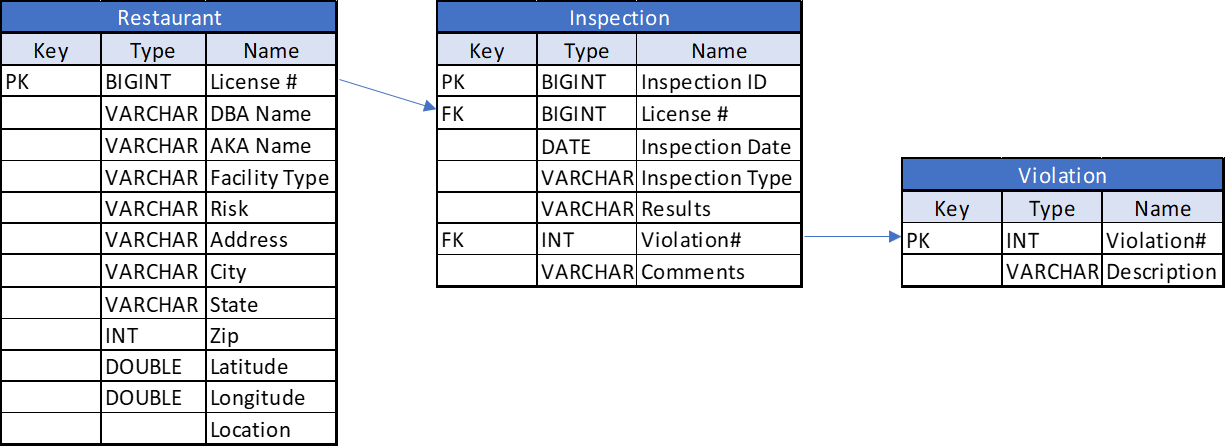

### ERD2
Updated concept to overcome non-unique license numbers, names etc.

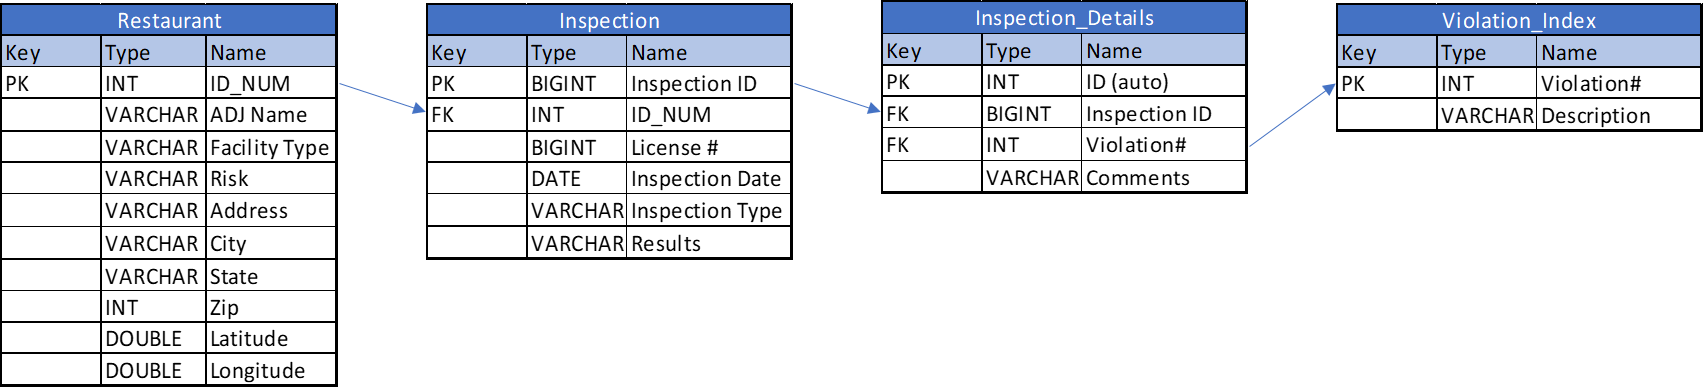

# Creating Database tables

## Insert Statements

In [3]:
db = sqlite3.connect(r"C:\sqlite\db\CS513.db")

In [20]:
drop_table_rest = "DROP TABLE restaurant;"
drop_table_insp = "DROP TABLE inspection;"
drop_table_insp_detail = "DROP TABLE inspection_detail"
drop_table_vio = "DROP TABLE violation"

In [21]:
create_table_rest = """
CREATE TABLE IF NOT EXISTS restaurant(
id_num INT PRIMARY KEY,
rest_name VARCHAR,
facility_type VARCHAR,
risk VARCHAR,
address VARCHAR,
city VARCHAR,
state VARCHAR,
zip INT,
lat REAL,
long REAL
);
"""

In [22]:
create_table_violation = """
CREATE TABLE IF NOT EXISTS violation(
violation_num INT PRIMARY KEY,
desc VARCHAR
);
"""

In [255]:
create_table_insp = """
CREATE TABLE IF NOT EXISTS inspection(
inspection_id BIGINT NOT NULL PRIMARY KEY,
id_num INT,
license BIGINT,
insp_date DATE,
insp_type VARCHAR,
results VARCHAR,
FOREIGN KEY (id_num) REFERENCES restaurant (id_num)
);
"""

In [24]:
create_table_insp_detail = """
CREATE TABLE IF NOT EXISTS inspection_detail(
id INTEGER PRIMARY KEY,
inspection_id BIGINT NOT NULL,
violation_num INT,
comments VARCHAR,
FOREIGN KEY (inspection_id) REFERENCES inspection (inspection_id),
FOREIGN KEY (violation_num) REFERENCES violation (violation_num)
);
"""

## Running and Confirming in cmdline

### Restaurant Table

In [293]:
#db.execute(drop_table_rest)
db.execute(create_table_rest)

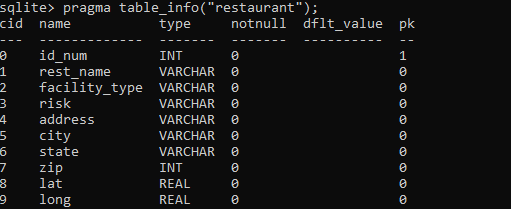

### Violation Table

In [30]:
#db.execute(drop_table_vio)
db.execute(create_table_violation)

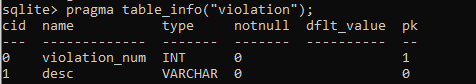

### Inspection Table

In [257]:
#db.execute(drop_table_insp)
db.execute(create_table_insp)

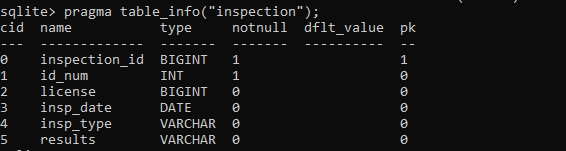

### Inspection_Detail Table

In [34]:
#db.execute(drop_table_insp_detail)
db.execute(create_table_insp_detail)

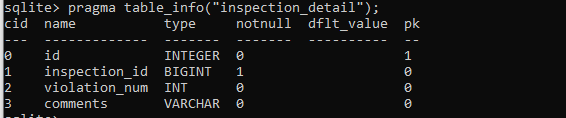

# Inserting Data Into The Tables
From here, after confirming that the tables exist in the local db, inserting the data is super straight forward with the help of the built in functionality with pandas.

If the data is in the shape it should be and the column names match the data base, I never had to use anything other than the following syntax:

```python
DATAFRAME_TO_INSERT.to_sql("TABLE_NAME", con=DATABASE_INSTANCE, if_exists='append', index=False)
```

#### The Data Itself
The data for the majority of the inserts comes straight out of OpenRefine, just exported as csv. This means that it should be close to clean and in good shape for insert.

The only exception is the violation data comes from the parsing function to split the violations and their comments.

## Adding Data to violation table

In [35]:
#Reading in Parsed Violations and formatting for insert
vio_df = pd.read_csv("Data/Violations_Parsed.csv")
vio_df = vio_df[['Violation #', 'Violation Desc']]
vio_df = vio_df.drop_duplicates(subset='Violation #')
vio_df = vio_df.sort_values(by='Violation #')

#Renaming to match existing db table's data names
vio_df.columns = ['violation_num','desc']

#Using Pandas to append data to existing db table
vio_df.to_sql('violation',con=db, if_exists='append',index=False)

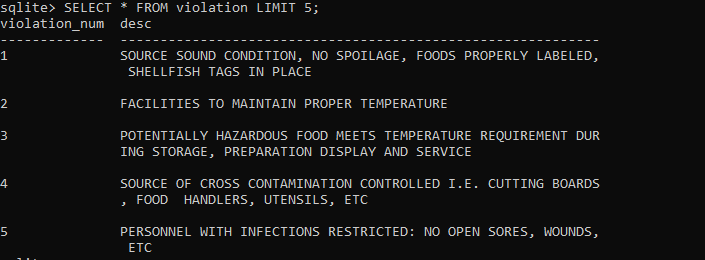

## Adding Data to Restaurant table

In [223]:
#loading in cleaned data from OpenRefine Project output
df = pd.read_csv("Data/Food_Inspections_OR2.csv")

In [243]:
rest_df = df[['DBA Name','Facility Type','Risk','Address','City','State','Zip','Latitude','Longitude']]

In [244]:
rest_df['Address']=rest_df['Address'].str.strip()

C:\Users\Tony\AppData\Local\Temp/ipykernel_16608/4141588242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_df['Address']=rest_df['Address'].str.strip()


In [294]:
rest_df = rest_df.drop_duplicates(subset=['DBA Name','Address'])
#rest_df = rest_df.dropna()
rest_df = rest_df.reset_index(drop=True)
rest_df.index.name = "ID_NUM"

In [227]:
#saving it and reading it back in
#saves it as well as gives the id_num column in the df
rest_df.to_csv("Data/restaurants.csv")
rest_df = pd.read_csv("Data/restaurants.csv")

In [296]:
rest_df

,id_num,rest_name,facility_type,risk,address,city,state,zip,lat,long
ID_NUM,,,,,,,,,,
0,0,MARRIOT MARQUIS CHICAGO,RESTAURANT,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,41.853651,-87.620534
1,1,SHRIMP FISH CHICKEN,RESTAURANT,Risk 2 (Medium),4355 S COTTAGE GROVE AVE,CHICAGO,IL,60653.0,41.815197,-87.606531
2,2,ART DRIVE INN,RESTAURANT,Risk 1 (High),1333 W NORTH AVE,CHICAGO,IL,60622.0,41.910601,-87.661863
3,3,VINCENT,RESTAURANT,Risk 1 (High),1475 W BALMORAL AVE,CHICAGO,IL,60640.0,41.979744,-87.667738
4,4,CAPTAIN HOOKS OF DAN RYAN,RESTAURANT,Risk 2 (Medium),205 W 87TH ST,CHICAGO,IL,60620.0,41.736030,-87.629095
...,...,...,...,...,...,...,...,...,...,...
15410,15410,MAKIA FOOD,NaN,Risk 3 (Low),2458 S CALIFORNIA AVE,CHICAGO,IL,60608.0,41.846516,-87.695423
15411,15411,THE DOGHOUSE,NaN,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,42.008536,-87.914428
15412,15412,DUNKIN DONUTS,RESTAURANT,Risk 2 (Medium),970 W PERSHING RD,CHICAGO,IL,60609.0,41.823504,-87.650666


In [295]:
rest_df.columns = ['id_num','rest_name','facility_type','risk','address','city','state','zip','lat','long']

In [203]:
rest_df.to_sql('restaurant',con=db, if_exists='append',index=False)

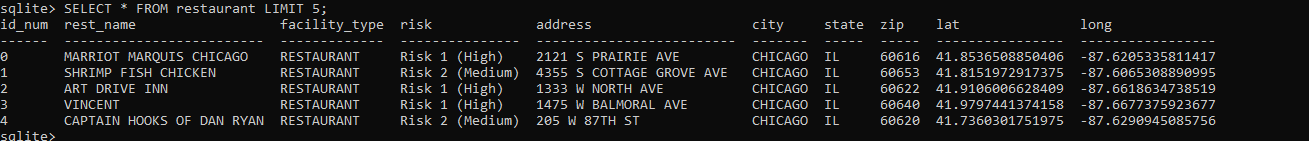

## Adding Data to Inspection table
This one required a bit more finnesse

In [266]:
insp_df = df[['Inspection ID','DBA Name','Address','License #','Inspection Date','Inspection Type','Results']]
insp_df['Address']=insp_df['Address'].str.strip()
insp_df['JoinCol']=insp_df['DBA Name']+insp_df['Address'].str.strip()

In [270]:
#Ensure All Key Values unique
len(np.unique(insp_df['Inspection ID']))==len(insp_df['Inspection ID']) 

True

In [271]:
#Use Restaraunt DF to get the ID nums for joining
#To ensure correct index match on the join, using a combination of the name and the address
tojoin = rest_df[['ID_NUM','DBA Name','Address']]
tojoin['JoinCol']=tojoin['DBA Name']+tojoin['Address'].str.strip()

In [274]:
insp_df = pd.merge(insp_df, tojoin, on='JoinCol', how='left')
insp_df = insp_df.drop(columns=['DBA Name_x','Address_x','JoinCol','DBA Name_y','Address_y'])

In [275]:
insp_df = insp_df[['Inspection ID',"ID_NUM",'License #','Inspection Date','Inspection Type','Results']]
insp_df.columns = ['inspection_id','id_num','license','insp_date','insp_type','results']

In [276]:
insp_df

,inspection_id,id_num,license,insp_date,insp_type,results
0,2079132,0.0,2517328.0,2017-08-28T00:00:00Z,License,Pass
1,2079123,0.0,2517338.0,2017-08-28T00:00:00Z,License,Pass
2,2079104,1.0,2549497.0,2017-08-28T00:00:00Z,License,Fail
3,2079091,2.0,64682.0,2017-08-25T00:00:00Z,Canvass,Fail
4,2079087,3.0,51614.0,2017-08-25T00:00:00Z,Complaint,Fail
...,...,...,...,...,...,...
96058,67732,12353.0,1992039.0,2010-01-04T00:00:00Z,License Re-Inspection,Pass
96059,67757,15247.0,1380279.0,2010-01-04T00:00:00Z,Tag Removal,Pass
96060,52234,15414.0,2013328.0,2010-01-04T00:00:00Z,License Re-Inspection,Pass
96061,70269,14540.0,1899292.0,2010-01-04T00:00:00Z,License Re-Inspection,Pass


In [258]:
insp_df.to_sql('inspection',con=db, if_exists='append',index=False)

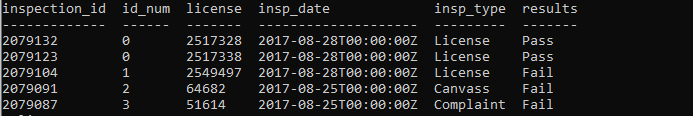

## Adding Data to Inspection_Detail table

In [284]:
vio_df = pd.read_csv("Data/Violations_Parsed.csv")
vio_df=vio_df[['Inspection ID','Violation #','Comments']]
vio_df = vio_df.reset_index(drop=False)
vio_df.columns =['id','inspection_id','violation_num','comments']

In [285]:
vio_df

,id,inspection_id,violation_num,comments
0,0,2079125,8,"NO DISH WASHING FACILITIES ON SITE, (NO THREE ..."
1,1,2079125,11,"NO EXPOSED HAND SINK FOR REAR SERVICE AREA, IN..."
2,2,2079125,18,NO LICENSE PEST CONTROL LOG BOOK AT THIS TIME ...
3,3,2079123,35,MUST PROVIDE OVERHEAD PROTECTION FOR COFFEE/TE...
4,4,2079123,34,FLOORS AT COFFEE/TEA STATIONS MUST BE MADE SMO...
...,...,...,...,...
568613,568613,104236,36,"All rooms in which food or drink is prepared, ..."
568614,568614,104236,37,None of the operations connected with food est...
568615,568615,104236,38,The flow of air discharged from kitchen fans s...
568616,568616,104236,39,"Soiled and clean linens, coats, and aprons sha..."


In [286]:
vio_df.to_sql('inspection_detail',con=db, if_exists='append',index=False)

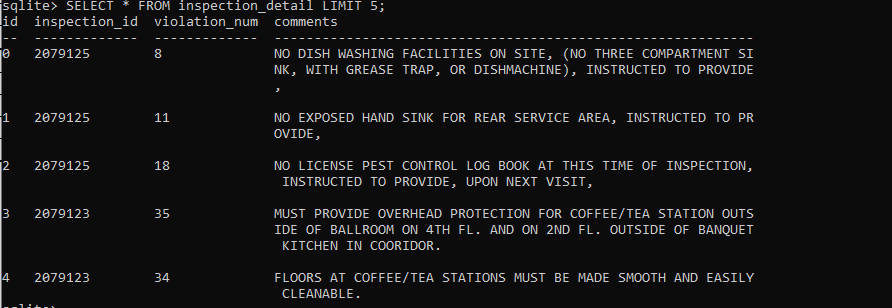

### At this point, everything should be in the local db

# Print from notebook examples
Just some quick examples of using this db instance to get printed outputs from queries

In [289]:
from pprint import pprint

In [290]:
cursor = db.execute("SELECT * FROM inspection_detail LIMIT 5")
out = cursor.fetchall()
pprint(out)

[(0,
  2079125,
  8,
  'NO DISH WASHING FACILITIES ON SITE, (NO THREE COMPARTMENT SINK, WITH GREASE '
  'TRAP, OR DISHMACHINE), INSTRUCTED TO PROVIDE,'),
 (1,
  2079125,
  11,
  'NO EXPOSED HAND SINK FOR REAR SERVICE AREA, INSTRUCTED TO PROVIDE,'),
 (2,
  2079125,
  18,
  'NO LICENSE PEST CONTROL LOG BOOK AT THIS TIME OF INSPECTION, INSTRUCTED TO '
  'PROVIDE, UPON NEXT VISIT,'),
 (3,
  2079123,
  35,
  'MUST PROVIDE OVERHEAD PROTECTION FOR COFFEE/TEA STATION OUTSIDE OF BALLROOM '
  'ON 4TH FL. AND ON 2ND FL. OUTSIDE OF BANQUET KITCHEN IN COORIDOR.'),
 (4,
  2079123,
  34,
  'FLOORS AT COFFEE/TEA STATIONS MUST BE MADE SMOOTH AND EASILY CLEANABLE.')]


In [292]:
cursor = db.execute('pragma table_info("inspection_detail")')
out = cursor.fetchall()
pprint(out)

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'inspection_id', 'BIGINT', 1, None, 0),
 (2, 'violation_num', 'INT', 0, None, 0),
 (3, 'comments', 'VARCHAR', 0, None, 0)]
